# Phase Change Indicator #6 (월간데이타)

##### 평균모멘텀스코어로 테스

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
from Library import FinanceLibrary as fl

In [2]:
df = pd.read_csv("..\\Data\\KOSPI_Daily_1980data.csv", encoding="utf-8")
df.index = pd.to_datetime(df["Date"])
df_close = df["Close"]
# 월간데이터 구하기
df_close = df_close.resample("BM")._upsample(None).interpolate()
# 데이타 기간
#df_close = df_close["1990":"2010"]
#df_close = df_close["2010":]
df_close = df_close["1988":]

df_close = np.round(df_close/df_close[0],2)  #re-scale
KOSPI = pd.DataFrame(df_close, index=df_close.index)

In [3]:
# fl.PhaseChangeIndicator(종가,기간)
Period = 6
PCI = fl.PhaseChangeIndicator(df_close,Period)

KOSPI["PCI"] = PCI
# PCI에 사용하는 모멘텀은 "현재 종가" - "전일 종가"
#KOSPI["Momentum"] = KOSPI["Close"] - KOSPI["Close"].shift(Period)
KOSPI["Momentum"] = fl.AverageMomentumScore(df_close,Period)

In [4]:
# Momentum > 0 이고, PCI < 20 일때 매수 
# Momentum < 0 이고, PCI > 80 일때 매도 
entry = []
entry_condition = 0.2
for i in range(len(KOSPI)):
    if KOSPI["Momentum"][i] > entry_condition and KOSPI["PCI"][i] < 30:  # 하락장에서 상승으로 전환, 횡보에서 상승으로 전환
        #entry.append("Buy")
        entry.append(1)
    elif KOSPI["Momentum"][i] < entry_condition and KOSPI["PCI"][i] > 70:  # 상승장에서 하락으로 전환, 횡보에서 하락으로 전환
        #entry.append("Sell")
        entry.append(0)
    elif KOSPI["Momentum"][i] < entry_condition and KOSPI["PCI"][i] < 30:  # 하락장에서 횡보로 전환
        #entry.append("Sell")
        entry.append(0)
    elif KOSPI["Momentum"][i] > entry_condition and KOSPI["PCI"][i] > 70:  # 상승장에서 횡보로 전환
        #entry.append("Sell")
        entry.append(0)
    else:
        entry.append(np.NaN)  # 20과 80사이는 상태를 정의할 수 없다. 아래 코드에서 이전 상태를 유지 한다.
KOSPI["Entry"] = entry
KOSPI["Entry"][0] = 0  # 첫번째 값을 "0"으로 세팅하여 현재 매도 상태임을 명시
#KOSPI["Entry"] = KOSPI["Entry"].fillna(method="ffill")  # NaN은 횡보임으로 앞의 값으로 채움

In [5]:
KOSPI["YesterdayReturn"] = np.round(fl.YesterdayReturn(KOSPI["Close"]),4)
KOSPI["YesterdayReturn"].iloc[0] = 1

avg = fl.AverageMomentumScore(df_close,Period)
# 진입조건 이상일때 진입한다
avg = avg.apply(lambda x : 1 if x > entry_condition else np.NaN)
KOSPI["MomentumReturn"] = np.round(KOSPI["YesterdayReturn"] * avg.shift(1),4)
KOSPI["MomentumReturn"].iloc[0] = 1
#cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.
KOSPI["MomentumReturn"] = KOSPI["MomentumReturn"].apply(lambda x: np.NaN if x == 0 else x)

# 매무 중요 진입 시그널은 어제것을 사용한다. 왜? 수익이 "어제 진입해서 오늘 확증"되는 수익률 임으로
KOSPI["TestingReturn"] = np.round(KOSPI["YesterdayReturn"] * KOSPI["Entry"].shift(1),4)
#cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.
KOSPI["TestingReturn"] = KOSPI["TestingReturn"].apply(lambda x: np.NaN if x == 0 else x)
KOSPI["TestingReturn"].iloc[0] = 1

# 평균모멘텀스코어 PCI
pci_avg_retrun = np.round(KOSPI["YesterdayReturn"] * KOSPI["Entry"].shift(1) * KOSPI["Momentum"].shift(1),4)
#cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.
KOSPI["PCIReturn"] = pci_avg_retrun + (1 - KOSPI["Momentum"].shift(1) * KOSPI["Entry"].shift(1))
KOSPI["PCIReturn"] = KOSPI["PCIReturn"].apply(lambda x: np.NaN if x == 0 else x)
KOSPI["PCIReturn"].iloc[0] = 1

# 평균모멘텀스코어 누적수익률
average_score = fl.AverageMomentumScore(df_close,Period)
average_return = KOSPI["YesterdayReturn"] * average_score.shift(1)  # 모멘텀 수익률 * 평균스코어만큼 진입
KOSPI["AverageMomentum"] = average_return + (1-average_score.shift(1))  # 평균모멘텀 수익률 = 평균모멘텀 수익률 + 현금(1-average_score)
KOSPI["AverageMomentum"] = KOSPI["AverageMomentum"].apply(lambda x: np.NaN if x == 0 else x)
KOSPI["AverageMomentum"].iloc[0] = 1

<function matplotlib.pyplot.show>

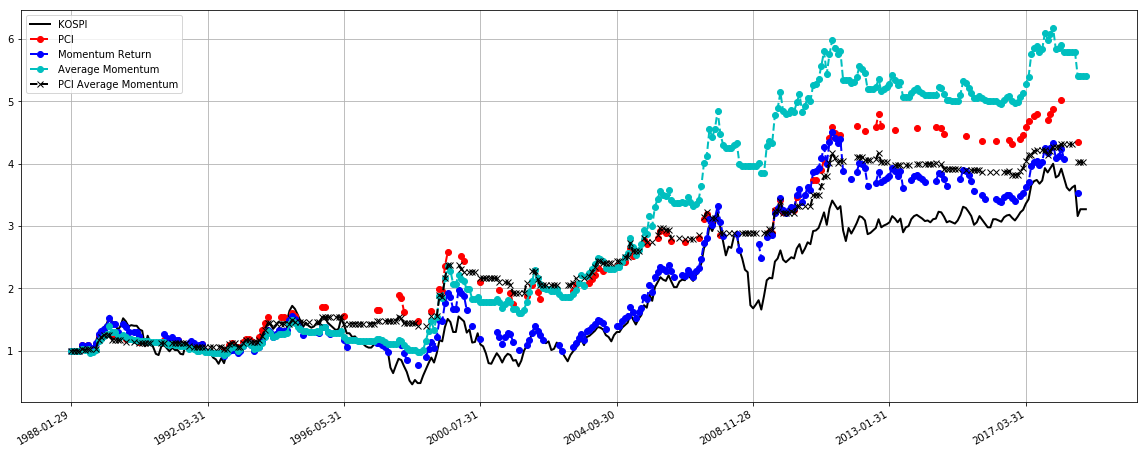

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

formatter = fl.MyFormatter(KOSPI.index)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(len(KOSPI)), KOSPI["YesterdayReturn"].cumprod(), color="Black", label="KOSPI")
ax.plot(np.arange(len(KOSPI)), KOSPI["TestingReturn"].cumprod(), color="Red", label="PCI", marker="o", linestyle="--")
ax.plot(np.arange(len(KOSPI)), KOSPI["MomentumReturn"].cumprod(), color="Blue", linestyle="--", marker="o", label="Momentum Return")
ax.plot(np.arange(len(KOSPI)), KOSPI["AverageMomentum"].cumprod(), color="C", linestyle="--",marker="o", label="Average Momentum")
ax.plot(np.arange(len(KOSPI)), KOSPI["PCIReturn"].cumprod(), color="K", linestyle="--",marker="x", label="PCI Average Momentum")
fig.autofmt_xdate()
ax.legend()
plt.show

In [7]:
a = fl.Portfolio(KOSPI["TestingReturn"].cumprod(),"PCI")
b = fl.Portfolio(KOSPI["PCIReturn"].cumprod(),"PCI AVG")
c = fl.Portfolio(KOSPI["AverageMomentum"].cumprod(),"AverageMomentum")
d = fl.Portfolio(KOSPI["MomentumReturn"].cumprod(),"MomentumReturn")
e = fl.Portfolio(KOSPI["YesterdayReturn"].cumprod(),"KOSPI")
f = pd.concat([a,b,c,d,e], axis=1)
f.T

,Initial Balnce,Final Balance,CAGR,Std,Max.Drawdown,Sharpe Ratio
PCI,1.0,4.347909,5.0210,1.300953,-32.4426,0.230250
PCI AVG,1.0,4.025441,4.5948,1.122256,-18.7842,0.169143
AverageMomentum,1.0,5.412681,5.4191,1.788983,-34.7482,0.132074
MomentumReturn,1.0,3.530098,4.1527,1.174449,-50.8285,0.107261
KOSPI,1.0,3.270467,3.7723,0.947052,-73.2595,0.080280


<function matplotlib.pyplot.show>

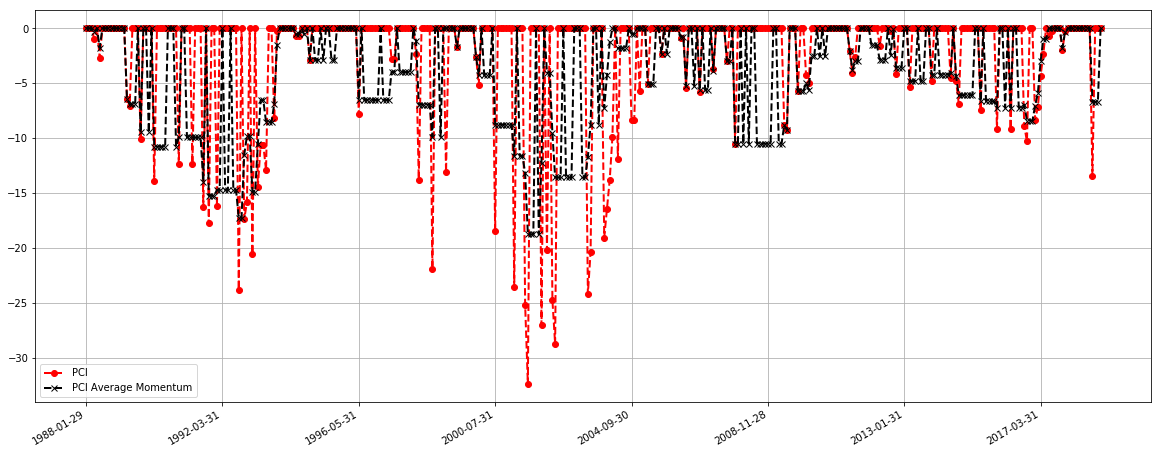

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

formatter = fl.MyFormatter(KOSPI.index)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)

a_dd,a_mdd = fl.MDD(KOSPI["YesterdayReturn"].cumprod())
a = a_dd.apply(lambda x:x if x < 0 else 0)
b_dd,b_mdd = fl.MDD(KOSPI["TestingReturn"].cumprod())
b = b_dd.apply(lambda x:x if x < 0 else 0)
c_dd,c_mdd = fl.MDD(KOSPI["MomentumReturn"].cumprod())
c = c_dd.apply(lambda x:x if x < 0 else 0)
d_dd,d_mdd = fl.MDD(KOSPI["AverageMomentum"].cumprod())
d = d_dd.apply(lambda x:x if x < 0 else 0)
e_dd,e_mdd = fl.MDD(KOSPI["PCIReturn"].cumprod())
e = e_dd.apply(lambda x:x if x < 0 else 0)

#ax.plot(np.arange(len(KOSPI)), a, color="Black", label="KOSPI")
#ax.plot(np.arange(len(KOSPI)), a_mdd)
ax.plot(np.arange(len(KOSPI)), b, color="Red", label="PCI", marker="o", linestyle="--")
#ax.plot(np.arange(len(KOSPI)),b_mdd)
#ax.plot(np.arange(len(KOSPI)), c, color="Blue", linestyle="--", marker="o", label="Momentum Return")
#ax.plot(np.arange(len(KOSPI)), d, color="C", linestyle="--",marker="o", label="Average Momentum")
ax.plot(np.arange(len(KOSPI)), e, color="K", linestyle="--",marker="x", label="PCI Average Momentum")
#ax.plot(np.arange(len(KOSPI)),e_mdd)
fig.autofmt_xdate()
ax.legend()
plt.show

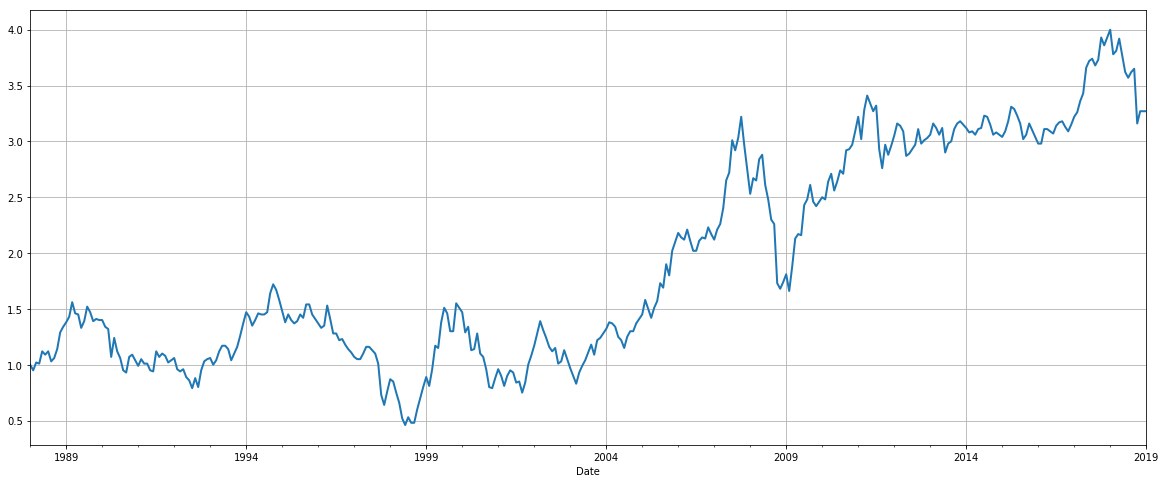

In [9]:
KOSPI["Close"].plot()